In [1]:
import pandas as pd
from shapely.geometry import Point, LineString, Polygon, MultiPoint
import shapely 
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import osmnx as ox
import requests
import yaml
import seaborn as sns

# Urban geospatial connectivity
This workshop takes an interested citizen through a series of analyses based on geospatial networks. The analyses are intended to showcase how open data and network algorithms can be used to understand the structure of urban environments and infer whether they work for us, the citizens. 

## Understanding the city with networks
- Basic routing on a network
    - How did you get to the conference?
- From a single route to many routes
    - Accessibility analysis with Pandana
- How walkable is Wellington?
    - Using playgrounds as a proxy for local walkability
    - Using street gradients to change walking times / distances
    - Using spatial filters to look at walkability by suburb
- Catchment areas of an amenity
    - Converting accessibility to isochrones
- What are the most connected suburbs?
    - Using network metrics to define connectivity
    - Best connected areas for walking
    - Well connected regions of public transit

# Data Science Foundations
But first, we need some foundations in topics relevant to getting, wrangling, analysing and visualising geospatial data. Topics include:
- data definitions
- data structures
- data retrieval
- data wrangling
- data visualisation

These topics are very important because even a relativlely simple analysis like understanding local walkability in Wellington will be a pipeline of sequential tasks:
- getting the playground locations
- downloading a street network
- computing accessibilities on the street network
- visualising accessibility

## Data structures and definitions
The groundwork for the analyses requires a minimal understanding of:

| Components | Topics |
|:----------:|:------:|
|data definitions | attribute table |
| | spatial primitives| 
| | networks (graphs)|
|data structures | dataframes | 
| | spatial dataframes|
| | graph dataframes| 


In [2]:
wcc_playgrounds = gpd.read_file('zip://../data/WCC_Playgrounds.zip')
wcc_playgrounds.head()

OBJECTID         location      suburb                playground Housing  \
0         1   Salamanca Road     Kelburn    Kelburn Park Play Area      No   
1         2   Farnham Street  Mornington  Farnham Street Play Area      No   
2         3  Harrison Street    Brooklyn        Harrison Play Area      No   
3         4   Jeypore Street  Berhampore  Jeypore Street Play Area      No   
4         5    Brooklyn Road    Brooklyn    Central Park Play Area      No   

                      geometry  
0  POINT (174.76973 -41.28487)  
1  POINT (174.76947 -41.31994)  
2  POINT (174.76482 -41.30601)  
3  POINT (174.77340 -41.32199)  
4  POINT (174.76810 -41.29968)

## Attribute table
- row per entity with attributes in columns
- Table of WCC playgrounds
    - row per playground
    - attributes: suburb, location, playground name, housing

## Spatial primitives
- POINT
- LINE
- POLYGON
    

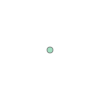

In [3]:
point = Point((0, 0))
point

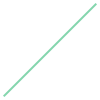

In [4]:
line = LineString([(0, 0), (1, 1)])
line

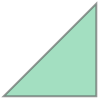

In [5]:
polygon = Polygon([(0, 0), (1, 1), (1, 0)])
polygon

## More complex spatial objects
- MultiPoint
- MultiLineString
- MultiPolygon    

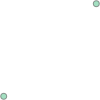

In [6]:
multipoints = MultiPoint([(0, 0), (1, 1)])
multipoints

## Networks
- Nodes
- Edges
    
When creating a graph, the node list is implicitly populated with the labels using the start and end of the edges.

In [7]:
G = nx.Graph()
G.add_edge('a', 'b')
G.add_edge('a', 'c')
G.add_edge('c', 'd')
G.add_edge('c', 'e')
G.add_edge('c', 'f')
G.add_edge('a', 'd')

### Plotting the network

/home/shrividya/anaconda2/envs/foss4g-workshop/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


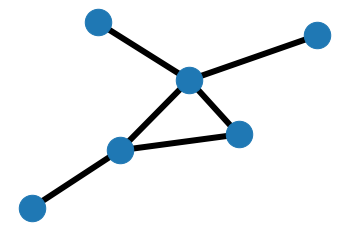

In [8]:
# positions for all nodes
pos = nx.spring_layout(G)  
# draw nodes
nx.draw_networkx_nodes(G, pos, node_size=700)
# draw edges
nx.draw_networkx_edges(G, pos, width = 6)
# Remove black bounding box
plt.axis('off')
plt.show()

### Setting node and edge attributes
Both nodes and edges can have associated attributes. 
- Nodes
    - magnitude
    - class
- Edges
    - weights
    - class
    - direction

In [9]:
attrs = {('a', 'b'): {'weight': 7}, 
         ('a', 'c'): {'weight': 2}, 
         ('c', 'd'): {'weight': 4}, 
         ('c', 'e'): {'weight': 10}, 
         ('c', 'f'): {'weight': 3}, 
         ('a', 'd'): {'weight': 1}}

nx.set_edge_attributes(G, attrs)

In [10]:
attrs = {'a': {'size': 100}, 
         'b': {'size': 200}, 
         'c': {'size': 400}, 
         'd': {'size': 100}, 
         'e': {'size': 300}, 
         'f': {'size': 100}}

nx.set_node_attributes(G, attrs)

### Plotting the network with additional attributes

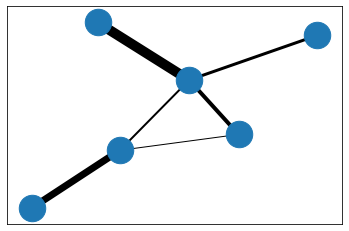

In [11]:
# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
nx.draw_networkx_edges(G, pos, width=weights)

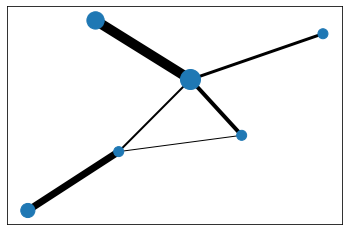

In [12]:
# nodes
nx.draw_networkx_nodes(G, pos, node_size=list(nx.get_node_attributes(G, 'size').values()))

# edges
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
nx.draw_networkx_edges(G, pos, width=weights)

## Data retrieval, wrangling and visualisation

| Components | Topics |
|:----------:|:------:|
| data retrieval / load | csv, excel | 
| | Overpass API|
| |  osmnx| 


### From file
The WCC playground locations can be downloaded from [here](https://data-wcc.opendata.arcgis.com/datasets/c3b0ae6ee9d44a7786b0990e6ea39e5d_0). 

In [13]:
# Read csv
csv_df = pd.read_csv('../data/WCC_Playgrounds.csv')
csv_df.head()

X          Y  OBJECTID         location      suburb  \
0  174.769735 -41.284873         1   Salamanca Road     Kelburn   
1  174.769465 -41.319940         2   Farnham Street  Mornington   
2  174.764823 -41.306009         3  Harrison Street    Brooklyn   
3  174.773402 -41.321988         4   Jeypore Street  Berhampore   
4  174.768104 -41.299679         5    Brooklyn Road    Brooklyn   

                 playground Housing  
0    Kelburn Park Play Area      No  
1  Farnham Street Play Area      No  
2        Harrison Play Area      No  
3  Jeypore Street Play Area      No  
4    Central Park Play Area      No

In [14]:
# Read geospatial data
wcc_playgrounds = gpd.read_file('zip://../data/WCC_Playgrounds.zip')
wcc_playgrounds.head()

OBJECTID         location      suburb                playground Housing  \
0         1   Salamanca Road     Kelburn    Kelburn Park Play Area      No   
1         2   Farnham Street  Mornington  Farnham Street Play Area      No   
2         3  Harrison Street    Brooklyn        Harrison Play Area      No   
3         4   Jeypore Street  Berhampore  Jeypore Street Play Area      No   
4         5    Brooklyn Road    Brooklyn    Central Park Play Area      No   

                      geometry  
0  POINT (174.76973 -41.28487)  
1  POINT (174.76947 -41.31994)  
2  POINT (174.76482 -41.30601)  
3  POINT (174.77340 -41.32199)  
4  POINT (174.76810 -41.29968)

For some analyses, it's useful to utilise area geometries. We'll use Wellington [suburban boundaries from WCC](https://data-wcc.opendata.arcgis.com/datasets/f534738cf3e648f7b1524a9697376764_0). 

In [15]:
wcc_suburbs = gpd.read_file('zip://../data/WCC_Suburbs_Boundaries.zip')
wcc_suburbs.head()

FID OBJECTID  postcode  supply_dat         suburb shape_STAr shape_STLe  \
0   58     None      6023    20030821     Berhampore       None       None   
1   59     None      6022    20030821    Breaker Bay       None       None   
2   60     None      6037    20060707   Churton Park       None       None   
3   61     None      6035    20030821  Crofton Downs       None       None   
4   62     None      6037    20030821       Glenside       None       None   

  Residentia Resident_1 Resident_2  \
0       None       None       None   
1       None       None       None   
2       None       None       None   
3       None       None       None   
4       None       None       None   

                                            geometry  
0  POLYGON ((174.77176 -41.31576, 174.77295 -41.3...  
1  POLYGON ((174.83776 -41.33159, 174.83755 -41.3...  
2  POLYGON ((174.80829 -41.18936, 174.81214 -41.1...  
3  POLYGON ((174.76112 -41.25283, 174.76139 -41.2...  
4  POLYGON ((174.82901 -41.18941, 174.82928 -41.1...

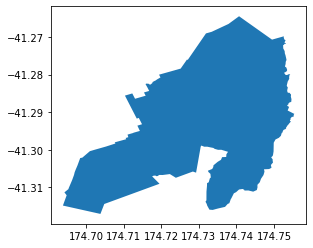

In [16]:
wcc_suburbs[wcc_suburbs['suburb'] == "Karori"].plot()

### Overpass API
Overpass is the read-only API for OpenStreetMap (OSM). 
> Overpass API allows you to query for OSM data by your own search criteria. For this purpose, it has two specifically crafted query languages: Overpass XML, and Overpass QL. 

For this workshop, we will only compose simple queries with Overpass QL. Since queries are strings, we can put them together programmatically using the expected structure. The query strings can be tested before running locally on: https://overpass-turbo.eu/

Query components:
- **Output format**: JSON, XML
- **Bounding box**: the area where we want the search performed. 
- **OSM data primitives**: ways, nodes, tags, relations.

The data primities of OSM have an intrinsic hierarchy with nodes being the root primitive. The primitives are split between spatial objects and object metadata.  

**Spatial objects**
- **Nodes**: Single point with explicit [lat, lon] coordinates.
- **Ways**: Collection of nodes that defines a polygon (e.g. a building) or polyline (e.g. a road). 

**Metadata**
- **Relations**: Represent the relationship of existing nodes and ways
- **Tags**: Metadata stored as key-value pairs. 

The main primitives we will used are nodes and tags. The nodes give the geolocation while we use the tags to filter specifically for the amenity of interest: playgrounds. 


**Resources** 
- More information about the entities of OpenStreetMap can be found [here](https://en.wikipedia.org/wiki/OpenStreetMap#Operation). 
- Full tutorial about the Overpass API language [here](https://wiki.openstreetmap.org/wiki/Overpass_API/Language_Guide)

#### Bounding Box
![](../assets/bounding-box-selection.png)

In [17]:
# Define bounding box (W, S, E, N) for the area of Wellington we're interested in
# Copied from http://boundingbox.klokantech.com/
general_bbox = [174.5813,-41.4552,175.0722,-41.1527]

# Separate out the bounding box list into 4 vertices. 
south = general_bbox[1]
west = general_bbox[0]
north = general_bbox[3]
east = general_bbox[2]

# Set OSM bounding box
osm_bbox = [south, west, north, east]

#### Construct Overpass query string to get playgrounds

In [18]:
# OSM data
tags = ['playground'] # in list for loop
objects = ['node'] # in list for loop: any of way, node, relation
entity = "leisure" # Query currently only supports one type of entity at a time

# Generate Query string
compactOverpassQLstring = '[out:json][timeout:60];('
for tag in tags:
    for obj in objects:
        compactOverpassQLstring += '%s["%s"="%s"](%s,%s,%s,%s);' % (obj, entity, tag,
                                                                    osm_bbox[0],
                                                                    osm_bbox[1],
                                                                    osm_bbox[2],
                                                                    osm_bbox[3])
compactOverpassQLstring += ');out body;>;out skel qt;'    

# look at query
print(compactOverpassQLstring)

[out:json][timeout:60];(node["leisure"="playground"](-41.4552,174.5813,-41.1527,175.0722););out body;>;out skel qt;


#### Test query
![](../assets/overpass-result-playgrounds.png)

#### Get query results and insert into dataframe

In [19]:
# Request data from Overpass
osmrequest = {'data': compactOverpassQLstring}
osmurl = 'http://overpass-api.de/api/interpreter'

# Ask the API
osm = requests.get(osmurl, params=osmrequest)

# Convert the results to JSON and get the requested data from the 'elements' key
# The other keys in osm.json() are metadata guff like 'generator', 'version' of API etc. 
osmdata = osm.json()
osmdata = osmdata['elements']

# Convert to dataframe
osm_df = pd.DataFrame(osmdata)
osm_df.head()

type          id        lat         lon  \
0  node   515641186 -41.214328  174.872375   
1  node   599440286 -41.212004  174.866961   
2  node   805148590 -41.214453  174.921932   
3  node  1127320937 -41.265101  174.762789   
4  node  1259073925 -41.229232  174.803435   

                                                tags  
0                          {'leisure': 'playground'}  
1                          {'leisure': 'playground'}  
2                          {'leisure': 'playground'}  
3     {'leisure': 'playground', 'p2pu': 'introvert'}  
4  {'leisure': 'playground', 'name': 'Gilbert You...

Need to extract the nested JSON inside the 'tags' column before producing the results dataframe

In [20]:
# Convert JSON output to pandas dataframe
for dct in osmdata:
    if 'tags' in dct:
        for key, val in dct['tags'].items():
            dct[key] = val
        del dct['tags']
    else:
        pass
osm_df = pd.DataFrame(osmdata)

Due to the hodgepodge nature of associated metadata in OSM, we get a very wide dataframe. But, that's fine since we mainly care about the fuel station brand, name and location. 

In [21]:
osm_df.head()

type          id        lat         lon     leisure       p2pu  \
0  node   515641186 -41.214328  174.872375  playground        NaN   
1  node   599440286 -41.212004  174.866961  playground        NaN   
2  node   805148590 -41.214453  174.921932  playground        NaN   
3  node  1127320937 -41.265101  174.762789  playground  introvert   
4  node  1259073925 -41.229232  174.803435  playground        NaN   

                      name wheelchair baby playground child amenity backrest  \
0                      NaN        NaN  NaN        NaN   NaN     NaN      NaN   
1                      NaN        NaN  NaN        NaN   NaN     NaN      NaN   
2                      NaN        NaN  NaN        NaN   NaN     NaN      NaN   
3                      NaN        NaN  NaN        NaN   NaN     NaN      NaN   
4  Gilbert Young Play Area        NaN  NaN        NaN   NaN     NaN      NaN   

  direction material playground_1 addr:street access max_age  
0       NaN      NaN          NaN         NaN    NaN     NaN  
1       NaN      NaN          NaN         NaN    NaN     NaN  
2       NaN      NaN          NaN         NaN    NaN     NaN  
3       NaN      NaN          NaN         NaN    NaN     NaN  
4       NaN      NaN          NaN         NaN    NaN     NaN

#### Exercise
- Put Overpass API query construction in function
- Use function to get an amenity in an area of your choice

### Osmnx
[osmnx](https://github.com/gboeing/osmnx) is a powerful Python package for spatial network analysis. It's the core package for this workshop since it allows the street network to retain spatial dimensions _and_ be manipulated as nodes and edges. 

The network representation of a map is particularly useful for applications that build on routing. Routes are _typically_ the shortest path between any two points. In our day to day lives, we're used to the Google Maps API doing this for us. But in fact we can create routes without Google - using network algorithms like [Djikstra's algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) to get the shortest path. We can use networkx's implementation, [nx.shortest_path](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html#networkx.algorithms.shortest_paths.generic.shortest_path), on spatial networks created by osmnx. Routing will be covered in Part 2 but we need to set up the foundations for these analyses here - including learning how to retreive, wrangle and visualise spatial networks. 

We'll go through 2 main ways to get street networks via osmnx:
- within a bounding box
- within a spatial boundary polygon

osmnx also has additional features: 
- enriching the street network with useful information e.g. elevation, building footprints
- calculating spatial network metrics including street orientations

In this workshop, we'll make considerable use of street elevation. Jupyter notebooks demonstrating the other features can be found [here](https://github.com/gboeing/osmnx-examples/tree/master/notebooks). 

#### Get Wellington walking network within bounding box
The bounding box used in the Overpass API example can also be used to bound the OSM query via osmnx. For this workshop, we will only be looking at the walking network. osmnx can extract the 'drive' network in addition to other networks, [subway](https://github.com/gboeing/osmnx-examples/blob/master/notebooks/00-osmnx-features-demo.ipynb) or infrastructure, using a string query.  

In [23]:
G = ox.graph_from_bbox(north, south, east, west, network_type='walk')
# Split the graph into node and edge dataframes 
G_nodes_df, G_edges_df = ox.graph_to_gdfs(G)

In [24]:
G_nodes_df.head()

y           x       osmid highway  \
1849753602 -41.170660  174.966235  1849753602     NaN   
292225031  -41.323010  174.776535   292225031     NaN   
292225032  -41.322351  174.776538   292225032     NaN   
292225035  -41.321551  174.777797   292225035     NaN   
3991535636 -41.182792  174.824669  3991535636     NaN   

                               geometry  
1849753602  POINT (174.96623 -41.17066)  
292225031   POINT (174.77654 -41.32301)  
292225032   POINT (174.77654 -41.32235)  
292225035   POINT (174.77780 -41.32155)  
3991535636  POINT (174.82467 -41.18279)

In [25]:
G_edges_df.head()

u           v  key      osmid             name      highway  \
0  1849753602   330141789    0   29989521  Farmer Crescent  residential   
1  1849753602  5995424095    0  107255522      High Street    secondary   
2  1849753602  3442158316    0  107255522      High Street    secondary   
3   292225031   292202539    0   26642190    Blythe Street  residential   
4   292225031  2701976329    0  149832487   Chatham Street  residential   

  maxspeed  oneway   length  \
0       50   False   84.486   
1       50   False   66.539   
2       50   False  179.408   
3       50   False  107.679   
4       50   False   44.311   

                                            geometry lanes service  ref  \
0  LINESTRING (174.96623 -41.17066, 174.96648 -41...   NaN     NaN  NaN   
1  LINESTRING (174.96623 -41.17066, 174.96628 -41...     2     NaN  NaN   
2  LINESTRING (174.96623 -41.17066, 174.96620 -41...     2     NaN  NaN   
3  LINESTRING (174.77654 -41.32301, 174.77661 -41...   NaN     NaN  NaN   
4  LINESTRING (174.77654 -41.32301, 174.77651 -41...   NaN     NaN  NaN   

  bridge junction access width tunnel landuse  
0    NaN      NaN    NaN   NaN    NaN     NaN  
1    NaN      NaN    NaN   NaN    NaN     NaN  
2    NaN      NaN    NaN   NaN    NaN     NaN  
3    NaN      NaN    NaN   NaN    NaN     NaN  
4    NaN      NaN    NaN   NaN    NaN     NaN

#### Get Wellington walking network within polygon
For local spatial analyses, it's very useful to constrain the osmnx spatial query to a boundary polygon instead of faffing about getting the bounding box just right. In the following example, we'll only the walking network for the Wellington suburb of Karori. 

In [26]:
karori = wcc_suburbs[wcc_suburbs['suburb'] == "Karori"]['geometry'].values[0]
G_karori = ox.graph_from_polygon(karori, network_type = "walk")

#### Ernrich Wellington walking network with elevation
Osmnx is able to enrich the street network, both nodes and edges, with elevation information from the [Google Elevation API](https://developers.google.com/maps/documentation/elevation/start). The retreived data is at the node level but osmnx calculates a gradient using basic trigonometry. 

- **street gradient** = *rise* / *run*
- *rise* = the difference in elevation between two connected nodes
- *run* = the length of the street segment between them. 

The street gradient can have any value between 0 and infinity which can be converted into an angle with an [inverse tangent transformation](https://en.wikipedia.org/wiki/Grade_(slope)). Gradients can also be converted to a percentage. 

<img src="../assets/street_gradient.png" alt="drawing" width="400"/>

In [28]:
# Open the API keys stored in a YAML file
with open("../utils/api_keys.yaml", 'r') as stream:
    data_loaded = yaml.safe_load(stream)

# Get Google Elevation API key
google_elevation_api_key = data_loaded['google_elevation_api_key'][0]

# Add elevation values for the nodes in the OSMNX graph
G_elev = ox.add_node_elevations(G, api_key=google_elevation_api_key)

# Generate an edge grade (inclination) with the elevations at the nodes
G_elev = ox.add_edge_grades(G_elev)

# Split the graph into node and edge dataframes 
G_elev_nodes_df, G_elev_edges_df = ox.graph_to_gdfs(G_elev)

### Data Visualisation 
| Components | Topics |
|:----------:|:------:|
| data visualisation | matplotlib | 
| | folium | 


#### Visualise street network with matplotlib

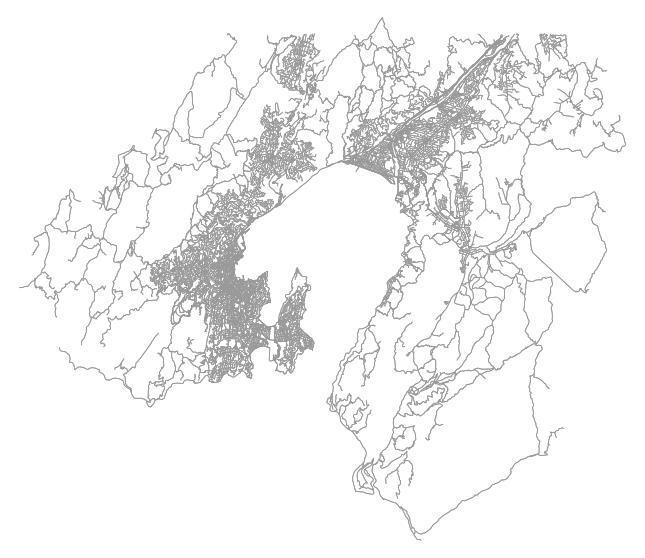

In [29]:
fig, ax = ox.plot_graph(G, fig_height=10, edge_linewidth=0.8, node_size=0, show=True)

#### Visualise street elevation

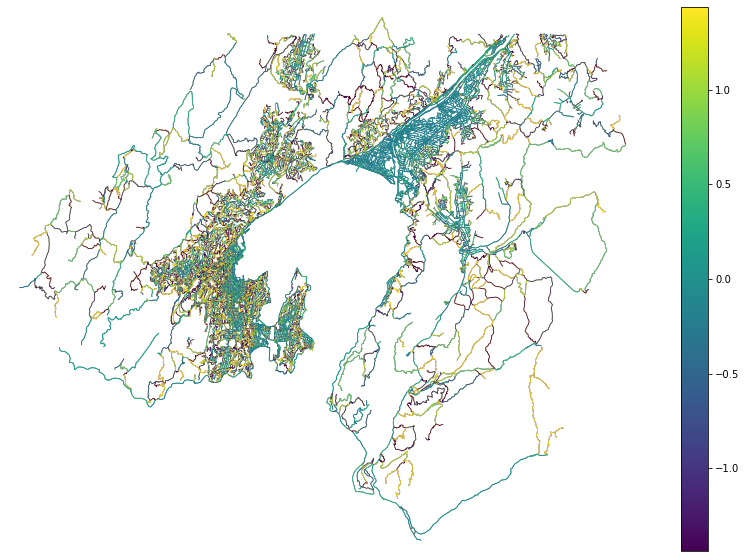

In [30]:
ec = ox.get_edge_colors_by_attr(G_elev, 'grade', cmap='viridis', num_bins=10)
fig, ax = ox.plot_graph(G, fig_height=10, edge_color=ec, edge_linewidth=0.8, node_size=0, show=False, close=False)

# Create colourbar
cmap = mpl.cm.get_cmap('viridis')
normalize = mpl.colors.Normalize(vmin=min(G_elev_edges_df['grade']),vmax=max(G_elev_edges_df['grade']))

# Add colourbar to axis
cax, _ = mpl.colorbar.make_axes(ax, location='right')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)

#### Interactive visualisation with folium

In [31]:
ox.plot_graph_folium(G_karori, popup_attribute='name', tiles='openstreetmap')

#### Exercise
For a better visualisation of Wellington's hilliness:
- plot street gradients as angle. 
- try out different colourmaps 
- try out a slope transformation e.g. exponential function

### Data wrangling
All data people, be they Analysts or Data Scientists, will groan at the extent of data wrangling that lies at the heart of any data analysis. This workshop is no exception. To do useful citizen data analyses, we need to be able to **transform**, **filter** and **summarise** data. Because the we using dataframes, networks and spatial data, we'll consider relevant data wrangling by each data structure. 

| Components | Topics |
|:----------:|:------:|
| data wrangling | attributes | 
| | graph data | 
| | spatial data

#### Manipulate dataframe attributes
The dataframe is the ubiquitous data structure common to networks, general datasets and spatial data. Common dataframe manipulations for spatial analyses include tidying up the messiness of OpenStreetMap data. Here, we'll look at tidying up the road speed attribute. Edges can contain more than one speed for a number of reasons. For example, a part of Troy St in Kilbirnie is associated with the 70kmph road to Wellington Airport. Osmnx pulls these multiple attributes into a Python list. 

Other fields with more than one value are also stored as lists. What's interesting though is that the single value are _not_ stored as lists. So, any cleaning of OSM data needs to take de-listification of attributes into account. 

In [81]:
def len_or_float(x):
    if type(x) == list:
        return(len(x))
    else:
        return(0)
  
speed_list = G_edges_df['maxspeed'].apply(len_or_float)
G_edges_df[speed_list > 1].head(5)

u           v  key  \
1885  3413772470  3413772485    0   
1906  3413772485  3413772470    0   
1968   333973807   178307233    0   
3752  1349063319   174888769    0   
4952  3358595061   267465664    0   

                                                  osmid  \
1885                               [41378432, 35893716]   
1906                               [41378432, 35893716]   
1968                              [639365684, 17169535]   
3752  [120284388, 120284389, 160183128, 160183130, 2...   
4952                              [16873488, 640842147]   

                       name    highway  maxspeed  oneway    length  \
1885            Troy Street  secondary  [70, 50]   False    69.427   
1906            Troy Street  secondary  [70, 50]   False    69.427   
1968     Takarau Gorge Road   tertiary  [50, 60]   False   910.359   
3752  Wainuiomata Hill Road  secondary  [50, 80]   False  3008.792   
4952          Willis Street  secondary  [30, 50]   False    70.140   

                                               geometry   lanes service  ref  \
1885  LINESTRING (174.80350 -41.31770, 174.80334 -41...     NaN     NaN  NaN   
1906  LINESTRING (174.80287 -41.31808, 174.80294 -41...     NaN     NaN  NaN   
1968  LINESTRING (174.77383 -41.20967, 174.77358 -41...     NaN     NaN  NaN   
3752  LINESTRING (174.92970 -41.25437, 174.92955 -41...  [2, 3]     NaN  NaN   
4952  LINESTRING (174.77470 -41.28917, 174.77441 -41...     NaN     NaN  NaN   

     bridge junction access width tunnel landuse  
1885    NaN      NaN    NaN   NaN    NaN     NaN  
1906    NaN      NaN    NaN   NaN    NaN     NaN  
1968    NaN      NaN    NaN   NaN    NaN     NaN  
3752    NaN      NaN    NaN   NaN    NaN     NaN  
4952    NaN      NaN    yes   NaN    NaN     NaN

In [64]:
G_edges_df.head()

u           v  key      osmid             name      highway  \
0  1849753602   330141789    0   29989521  Farmer Crescent  residential   
1  1849753602  5995424095    0  107255522      High Street    secondary   
2  1849753602  3442158316    0  107255522      High Street    secondary   
3   292225031   292202539    0   26642190    Blythe Street  residential   
4   292225031  2701976329    0  149832487   Chatham Street  residential   

  maxspeed  oneway   length  \
0       50   False   84.486   
1       50   False   66.539   
2       50   False  179.408   
3       50   False  107.679   
4       50   False   44.311   

                                            geometry lanes service  ref  \
0  LINESTRING (174.96623 -41.17066, 174.96648 -41...   NaN     NaN  NaN   
1  LINESTRING (174.96623 -41.17066, 174.96628 -41...     2     NaN  NaN   
2  LINESTRING (174.96623 -41.17066, 174.96620 -41...     2     NaN  NaN   
3  LINESTRING (174.77654 -41.32301, 174.77661 -41...   NaN     NaN  NaN   
4  LINESTRING (174.77654 -41.32301, 174.77651 -41...   NaN     NaN  NaN   

  bridge junction access width tunnel landuse  
0    NaN      NaN    NaN   NaN    NaN     NaN  
1    NaN      NaN    NaN   NaN    NaN     NaN  
2    NaN      NaN    NaN   NaN    NaN     NaN  
3    NaN      NaN    NaN   NaN    NaN     NaN  
4    NaN      NaN    NaN   NaN    NaN     NaN

In [33]:
# Awkward list in column because some edges have more than 1 speed
speeds = G_edges_df['maxspeed'].apply(pd.Series).rename(columns={0: 'speed', 1: 'additional_speed'})

In [34]:
# Add new columns to main edges dataframe
G_new_edges_df = pd.concat([G_edges_df, speeds], axis=1)
G_new_edges_df['speed'].fillna('0', inplace=True)

#### Filter street network

In [35]:
# Create new graph with additional speed columns 
new_G = ox.gdfs_to_graph(G_nodes_df, G_new_edges_df)

Filtering the graph is easiest done by creating a new graph with the required attributes

In [36]:
speeds = ['50']
H = nx.MultiDiGraph()
for u,v,attr in new_G.edges(data=True):
    if attr['speed'] in speeds:
        H.add_edge(u,v,attr_dict=attr)
        H.node[u].update(new_G.node[u])
        H.node[v].update(new_G.node[v])
        
H.graph['crs'] = new_G.graph['crs']
H.graph['name'] = new_G.graph['name']

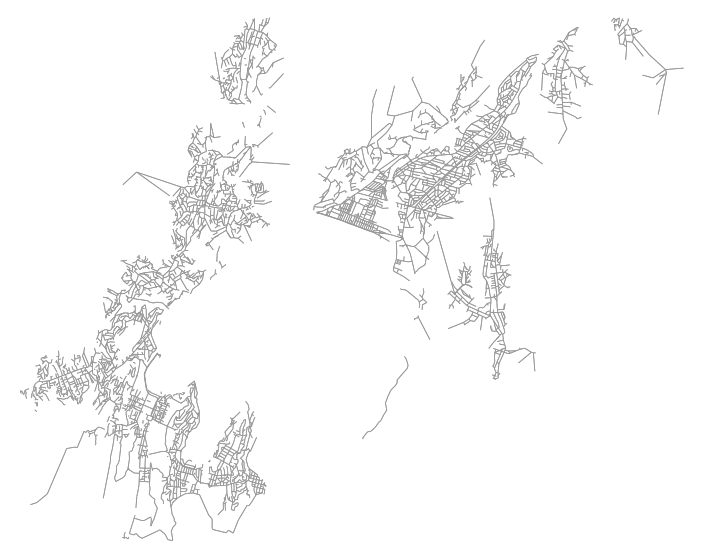

In [37]:
fig, ax = ox.plot_graph(H, fig_height=10, edge_linewidth=0.8, node_size=0, show=True)

The graph is clearly sparse. We'd expect most of the streets and roads to have 50km/h maximum speed. Unfortunately, this is the downside of using OSM data: not all attributes are available. In some cases, attributes _could_ even be incorrect. It's worth checking data against other known datasets / domain knowledge before doing any analysis!

In [38]:
G_new_edges_df['speed'].value_counts()

0      31368
50     23000
40       404
30       278
70       218
80       116
60        74
10        74
100       58
5         26
20        18
Name: speed, dtype: int64

#### Tidy up elevation visualisation

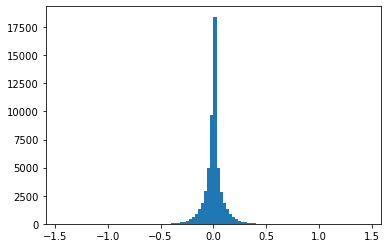

In [39]:
plt.hist(G_elev_edges_df['grade'], 100);

In [40]:
# Convert MultiDigraph to Undirected graph
G_elev_undir = G_elev.to_undirected()
nodes_gdfs_undir, edges_gdfs_undir = ox.graph_to_gdfs(G_elev_undir)

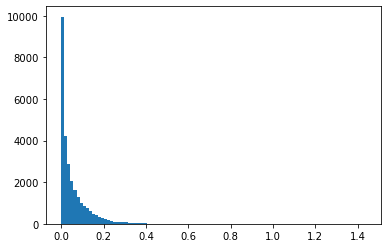

In [41]:
plt.hist(edges_gdfs_undir['grade_abs'], 100);

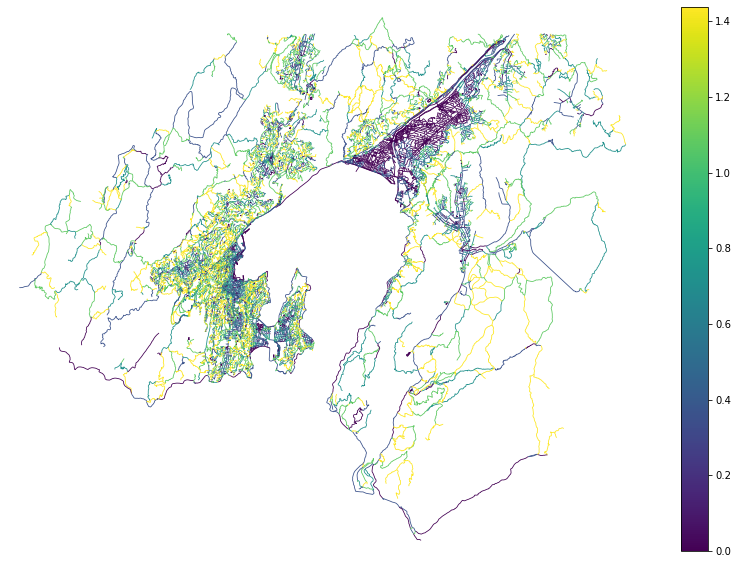

In [42]:
ec = ox.get_edge_colors_by_attr(G_elev_undir, 'grade_abs', cmap='viridis', num_bins=5)
fig, ax = ox.plot_graph(G_elev_undir, fig_height=10, edge_color=ec, edge_linewidth=0.8, node_size=0, show=False, close=False)

# Create colourbar 
cmap = mpl.cm.get_cmap('viridis')
normalize = mpl.colors.Normalize(vmin=min(edges_gdfs_undir['grade_abs']),vmax=max(edges_gdfs_undir['grade_abs']))

# Add colourbar to axis
cax, _ = mpl.colorbar.make_axes(ax, location='right')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)

#### Exercise
- Filter the osmnx graph with elevation to only those streets and roads with less than 5% gradient. 
- HINT: Use a for loop to filter the graph by attributes 

In [43]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

